# Installation

### 1. Make new conda environment
Install JAX by creating a fresh `conda` environment. 

As a side note, [`mamba`](https://mamba.readthedocs.io/en/latest/installation/mamba-installation.html) is a fast version of `conda` that uses `conda-forge` as its main channel (this is the channel you should always be using for science work).

With `conda` (`mamba` already does this by default):
```bash
conda update conda
conda config --add channels conda-forge
conda config --set channel_priority strict
```
Make environment:
```bash
conda create -n jax_intro python=3.12
conda activate jax_intro
```

### 2. Install JAX

Using JAX requires installing two packages: `jax`, which is pure Python and cross-platform, and `jaxlib` which contains compiled binaries, and requires different builds for different operating systems and accelerators.

-- CPU-only (Linux/macOS/Windows):
```bash
pip install -U jax
```

-- GPU (NVIDIA, CUDA 12):
```bash
pip install -U "jax[cuda12]"
```

-- GPU (Mac M chips): (Experimental)

Follow: https://developer.apple.com/metal/jax/
```bash
pip install -U "jax[cuda12]"
```

### 3. Install remaining packages
```bash
conda install matplotlib numpy scipy astropy h5py
```



# Import Matplotlib

In [1]:
%matplotlib inline

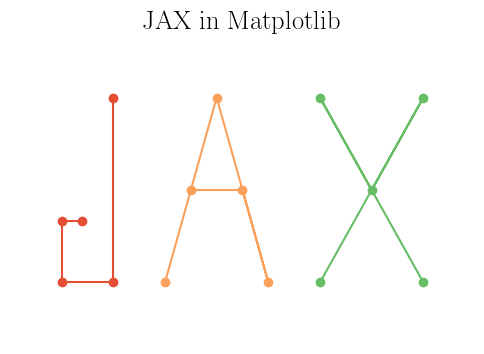

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rc('font', family="serif")
plt.rc('font', size=16)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
plt.rc('figure', figsize=(6,4)) 

cmap = plt.get_cmap("RdYlGn")
plt.subplots(1,1)
# Define points for "J"
J_x = [1, 1, 0, 0, 0.4]
J_y = [3, 0, 0, 1, 1]

# Define points for "A"
A_x = [2, 3, 4, 3.5, 2.5]
A_y = [0, 3, 0, 1.5, 1.5]

# Define points for "X"
X_x = [5, 7, 6, 5, 7]
X_y = [0, 3, 1.5, 3, 0]

# Plot the points as lines
plt.plot(J_x, J_y, marker='o', linestyle='-', color=cmap(0.15), label='J')
plt.plot(A_x, A_y, marker='o', linestyle='-', color=cmap(0.28), label='A')
plt.plot(X_x, X_y, marker='o', linestyle='-', color=cmap(0.8), label='X')

# Styling
plt.xlim(-1, 8)
plt.ylim(-1, 4)
plt.axis("off")
plt.title("JAX in Matplotlib")

# Show the plot
plt.show()

# Introduction to JAX

This notebook summarizes with examples some of the great JAX documentation available at: https://docs.jax.dev/en/latest/quickstart.html

JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

Even if you are not interested in machine learning, you can exploit JAX to make your programs **faster** and **differentiable**.

Coding with JAX is largely similar to coding with Numpy and Python's pure functions, with minimal (but important) rules, that yields accelerated code in CPUs, and automatic portability to accelerated machines (GPUs, TPUs).

JAX let's you calculate fast gradients with machine-level precision of your functions. The feature of differentiation let's you use modern gradient-based optimization (BFGS, Adam) or inference (HMC, NUTS) techniques. These converge much faster.

## Quickstart
JAX is a library for array-oriented numerical computation (à la NumPy), with automatic differentiation and JIT compilation to enable high-performance machine learning research.

The main features of JAX can be summarized as: 
- `jax.numpy`: JAX provides a unified *NumPy-like* interface to computations that run on *CPU, GPU, or TPU, in local or distributed settings*.

- `jax.jit`: JAX features built-in *Just-In-Time (JIT)* compilation via *Open XLA*, an open-source machine learning compiler ecosystem.

- `jax.grad`: JAX functions support efficient evaluation of gradients via its *automatic differentiation* transformations.

- `jax.vmap`: JAX functions can be *automatically vectorized* to efficiently map them over arrays representing batches of inputs.


JAX has also implemented part of scipy, accessible through `jax.scipy`.

# Jax as Numpy 

You can think of JAX as a differentiable Numpy that runs on accelerators.

Most JAX usage is through the familiar `jax.numpy` API, which is typically imported under the `jnp` alias:

In [3]:
import jax
import numpy as np
import jax.numpy as jnp

In [4]:
np_xarr = np.linspace(0, 2*jnp.pi, 50)
jnp_xarr = jnp.linspace(0, 2*jnp.pi, 50)
np_yarr = np.cos(np_xarr)
jnp_yarr = jnp.cos(jnp_xarr)

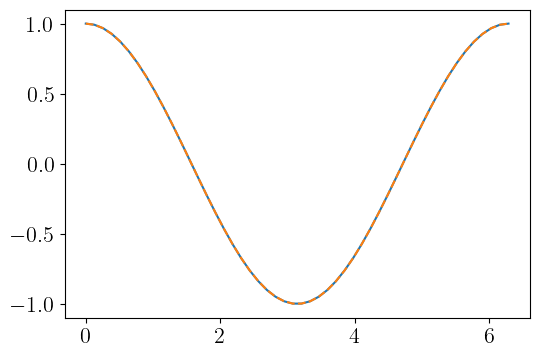

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(np_xarr, np_yarr)
ax.plot(jnp_xarr, jnp_yarr, ls='--')
plt.show()

# Basics
### JAX Arrays

The default array implementation in JAX is `jax.Array`. In many ways it is similar to the `numpy.ndarray` type that you may be familiar with from the NumPy package, but it has some important differences.



In [6]:
x_jnp = jnp.arange(5)
print(isinstance(x_jnp, jax.Array))
x_np = np.arange(5)
print(isinstance(x_np, np.ndarray))


True
True


In [7]:
x_jnp, x_np

(Array([0, 1, 2, 3, 4], dtype=int32), array([0, 1, 2, 3, 4]))

In [8]:
print(x_jnp, x_np)


[0 1 2 3 4] [0 1 2 3 4]


The `devices` method let's you know where the contents of the array are stored. 

In the simplest case, this is a single CPU device.

In [9]:
x_jnp.devices()

{CpuDevice(id=0)}

The `sharding` attribute let's you inspect how the array is stored in different devices. 

*Sharding* is a way of storing and distributing an array into multiple devices, so that operations can be carried out in parallel. 

In [10]:
x_jnp.sharding

SingleDeviceSharding(device=CpuDevice(id=0))

## Transformations

Along with functions to operate on arrays, JAX includes a number of transformations which operate on JAX functions. These include

- `jax.jit()`: Just-in-time (JIT) compilation; see Just-in-time compilation

- `jax.vmap()`: Vectorizing transform; see Automatic vectorization

- `jax.grad()`: Gradient transform; see Automatic differentiation


JAX accomplishes this by reducing each function into a sequence of *primitive* operations, each representing one fundamental unit of computation.

One way to see the sequence of primitives behind a function is using `jax.make_jaxpr()`:

In [11]:
def some_function(x):
    x = x + 2.0
    x = 7.0 * x
    x = x - 8.0
    x = x ** 2.0
    x = jnp.log(x)
    return x

xarr = jnp.arange(5.0)
print(jax.make_jaxpr(some_function)(xarr))

{ lambda ; a:f32[5]. let
    b:f32[5] = add a 2.0
    c:f32[5] = mul 7.0 b
    d:f32[5] = sub c 8.0
    e:f32[5] = pow d 2.0
    f:f32[5] = log e
  in (f,) }


We see that it encodes the precise sequence of operations that the function represents.

Now a more complicated example:

In [12]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
jax.make_jaxpr(selu)(x)

{ lambda ; a:f32[5]. let
    b:bool[5] = gt a 0.0
    c:f32[5] = exp a
    d:f32[5] = mul 1.6699999570846558 c
    e:f32[5] = sub d 1.6699999570846558
    f:f32[5] = pjit[
      name=_where
      jaxpr={ lambda ; g:bool[5] h:f32[5] i:f32[5]. let
          j:f32[5] = select_n g i h
        in (j,) }
    ] b a e
    k:f32[5] = mul 1.0499999523162842 f
  in (k,) }

Note how it also stores the type of the array that has been input `f32[5]`, i.e. a float32 array of length.

# Just-in-time compilation

Now we will discuss the `jax.jit()` transformation, which will perform *Just In Time* (JIT) compilation of a JAX Python function so it can be executed efficiently in XLA.

XLA, Short for *Accelerated Linear Algebra*, is a domain-specific compiler for linear algebra operations that is the primary backend for JIT-compiled JAX code. See https://www.tensorflow.org/xla/.



In [13]:
from jax import jit as jjit
from jax import random

We can use IPython’s `%timeit` to quickly benchmark our selu function, using `block_until_ready()` to account for JAX’s dynamic dispatch:

In [14]:
key = random.key(1701)
x = random.normal(key, (1_000_000,))

def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1e6)

In [15]:
%timeit selu(x).block_until_ready()

1.26 ms ± 55.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can speed the execution of this function with the `jax.jit()` transformation, which will jit-compile the first time selu is called and will be cached thereafter.

In [16]:
selu_jit = jjit(selu)
_ = selu_jit(x)  # compiles on first call

In [17]:
%timeit selu_jit(x).block_until_ready()

245 μs ± 27.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We achieved a 3x speed-up! (in my machine at least)

Here’s what just happened:

1. We defined `selu_jit` as the compiled version of selu.

2. We called `selu_jit` once on `x`. This is where JAX does its tracing – it needs to have some inputs to wrap in tracers, after all. The jaxpr is then compiled using XLA into very efficient code optimized for your GPU or TPU. Finally, the compiled code is executed to satisfy the call. Subsequent calls to `selu_jit` will use the compiled code directly, **skipping** the python implementation entirely. (If we didn’t include the warm-up call separately, everything would still work, but then the compilation time would be included in the benchmark. It would still be faster, because we run many loops in the benchmark, but it wouldn’t be a fair comparison.)

3. We timed the execution speed of the compiled version. (Note the use of `block_until_ready()`, which is required due to JAX’s Asynchronous dispatch).

Here is another example, comparing a matrix multiplication using `numpy.dot` or using a jitted version of `jax.numpy.dot`:

In [18]:
def matrix_product_numpy(x, alpha=1.67, lmbda=1.05):
    M = np.dot(x, x) + 3.0
    M = lmbda * np.where(M > 0, M, alpha * np.exp(M) - alpha)
    return M


def matrix_product_jax(x, alpha=1.67, lmbda=1.05):
    M = jnp.dot(x, x) + 3.0
    M = lmbda * jnp.where(M > 0, M, alpha * jnp.exp(M) - alpha)
    return M

matrix_product_jjit = jax.jit(matrix_product_jax)

xarr = np.random.uniform(size=(1000, 1000))

_ = matrix_product_jjit(xarr)  # compiles on first call

In [19]:
%time matrix_product_numpy(xarr)

CPU times: user 172 ms, sys: 3.53 ms, total: 176 ms
Wall time: 18.5 ms


array([[270.64411507, 272.0631195 , 267.65392036, ..., 278.65423419,
        268.20052426, 280.39657554],
       [256.7207096 , 264.43085532, 267.32327589, ..., 271.35066978,
        265.38861409, 270.98834242],
       [270.68819877, 271.1221135 , 274.9292116 , ..., 274.59219076,
        271.47412766, 269.85713547],
       ...,
       [262.07825899, 267.02729343, 268.47884206, ..., 269.18771482,
        266.15500657, 271.04614234],
       [262.53767667, 271.04054231, 266.25818619, ..., 271.65161386,
        268.01094871, 267.85552969],
       [258.61051177, 266.84918446, 265.75193443, ..., 271.42429646,
        263.13379127, 273.96742815]])

In [20]:
%time matrix_product_jjit(xarr).block_until_ready()

CPU times: user 94 ms, sys: 10.1 ms, total: 104 ms
Wall time: 9.52 ms


Array([[270.64404, 272.06314, 267.654  , ..., 278.65424, 268.20053,
        280.3966 ],
       [256.72067, 264.4308 , 267.3233 , ..., 271.35065, 265.38858,
        270.98837],
       [270.68817, 271.12204, 274.92923, ..., 274.5922 , 271.47412,
        269.85718],
       ...,
       [262.07822, 267.02728, 268.4788 , ..., 269.1877 , 266.155  ,
        271.0461 ],
       [262.53763, 271.04053, 266.25818, ..., 271.6516 , 268.01096,
        267.85553],
       [258.6105 , 266.8492 , 265.7519 , ..., 271.4243 , 263.1338 ,
        273.96738]], dtype=float32)

**This is a 10x speedup!!**

Alternatively, one can directly use the `@jax.jit` decorator to jit a function:

In [21]:
@jax.jit
def matrix_product_jax(x, alpha=1.67, lmbda=1.05):
    M = jnp.dot(x, x) + 3.0
    M = lmbda * jnp.where(M > 0, M, alpha * jnp.exp(M) - alpha)
    return M

_ = matrix_product_jax(xarr)  # compiles on first call

%time matrix_product_jax(xarr).block_until_ready()

CPU times: user 137 ms, sys: 1.72 ms, total: 139 ms
Wall time: 11 ms


Array([[270.64404, 272.06314, 267.654  , ..., 278.65424, 268.20053,
        280.3966 ],
       [256.72067, 264.4308 , 267.3233 , ..., 271.35065, 265.38858,
        270.98837],
       [270.68817, 271.12204, 274.92923, ..., 274.5922 , 271.47412,
        269.85718],
       ...,
       [262.07822, 267.02728, 268.4788 , ..., 269.1877 , 266.155  ,
        271.0461 ],
       [262.53763, 271.04053, 266.25818, ..., 271.6516 , 268.01096,
        267.85553],
       [258.6105 , 266.8492 , 265.7519 , ..., 271.4243 , 263.1338 ,
        273.96738]], dtype=float32)

### Tracing

The magic behind transformations is the notion of a Tracer. Tracers are abstract stand-ins for array objects, and are passed to JAX functions in order to extract the sequence of operations that the function encodes.

You can see this by printing any array value within transformed JAX code; for example:

In [22]:
@jjit
def some_function(x):
    x = x + 2.0
    x = 7.0 * x
    x = x - 8.0
    x = x ** 2.0
    x = jnp.log(x)
    print(x)
    return x

x = jnp.arange(5.0)
result = some_function(x)


Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>


The value printed is not the array `x`, but a `Tracer` instance that represents essential attributes of `x`, such as its shape and dtype. 

By executing the function with traced values, JAX can determine the sequence of operations encoded by the function before those operations are actually executed: transformations like `jit()`, `vmap()`, and `grad()` can then map this sequence of input operations to a transformed sequence of operations.



# Not everything can be jitted

## Conditioning

In [23]:
# Condition on value of x.

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

jax.jit(f)(10)  # Raises an error

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /var/folders/sc/d9pxkcm97k35gtbv8ttw2gvm0000gn/T/ipykernel_88034/2956679937.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

This can be solved by using `jax.lax.cond`

### jax.lax.cond

`jax.lax.cond(pred, true_fun, false_fun, *operands)`

Conditionally apply true_fun or false_fun.

In [24]:
# Function using lax.cond instead of a regular if statement
def f(x):
    return jax.lax.cond(x > 0, 
                    lambda x: x,      # Case when x > 0
                    lambda x: 2 * x,  # Case when x <= 0
                    operand=x)        # Pass x to both branches

# JIT compile the function
f_jit = jax.jit(f)

# Test cases
print(f_jit(10))  # Should return 10
print(f_jit(-5))  # Should return -10
print(f_jit(0))   # Should return 0

10
-10
0


Another option here would be to simply use `jnp.where`:

In [25]:
def f(x):
  return jnp.where(x > 0, x, 2 * x)

jax.jit(f)(10) 

Array(10, dtype=int32, weak_type=True)

`jax.lax.cond` has equivalent semantics to this Python implementation, where pred must be a scalar type:

In [26]:
def cond(pred, true_fun, false_fun, *operands):
  if pred:
    return true_fun(*operands)
  else:
    return false_fun(*operands)

Here is a more general example using `jax.lax.cond`, where you might call two completely different, aribtrarily complex functions for each True/False case.

In [27]:
# Define two functions: one for when the condition is True, another for False
def true_fun(x):
    return x ** 2  # Square the input

def false_fun(x):
    return x + 10  # Add 10 to the input

# Conditional function using lax.cond
def compute(x, condition):
    return jax.lax.cond(condition, true_fun, false_fun, x)

# Example inputs
x_val = 5
condition_val = True  # Try changing this to False

# JIT compile for speed
compute_jit = jax.jit(compute)

# Run the function
result = compute_jit(x_val, condition_val)
print("Result:", result)

Result: 25


## Loops and whiles

In [28]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

jax.jit(g)(10, 20)  # Raises an error


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function g at /var/folders/sc/d9pxkcm97k35gtbv8ttw2gvm0000gn/T/ipykernel_88034/4015687651.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument n.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

Can be solved in different ways. For example, by jitting only the intter function:

In [29]:
# While loop conditioned on x and n with a jitted body.
@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

Also by marking arguments as static, with `static_argnums` or `static_argnames`:

In [30]:
# Using argnums
f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(10))

# Using argnames
g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

10
30


Or by using python's `functools.partial()`:

In [31]:
# Using python's functools.partial()
 
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

print(g_jit_decorated(10, 20))

30


### jax.lax.while_loop

The same idea may be implemented using `jax.lax.while_loop`.

This function has the following inputs: `jax.lax.while_loop(cond_fun, body_fun, init_val)`.

And it basically calls `body_fun` repeatedly in a loop while `cond_fun` is True.

The semantics of while_loop are given by this Python implementation:

In [32]:
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

In [33]:
# Using python's jax.lax.while_loop.

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
    def cond_fun(state):
        i, _ = state
        return i < n  # Continue looping while i < n

    def body_fun(state):
        i, x_val = state
        return i + 1, x_val  # Increment i

    i_final, _ = jax.lax.while_loop(cond_fun, body_fun, (0, x))
    return x + i_final

print(g_jit_decorated(10, 20))  # Output: 30

30


### jax.lax.scan

The same idea may be implemented using `jax.lax.scan`.

`jax.lax.scan(f, init, xs=None, length=None)`

**When Should `jax.lax.scan` Be Used?**

`jax.lax.scan` is useful when performing sequential computations where the next step depends on the previous step. It is JAX’s optimized alternative to Python loops (for or while). 

The semantics of `scan()` are given roughly by this Python implementation:

In [34]:
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)

Here is an example from the code from before:

In [35]:
@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
    def body_fun(carry, _):
        i, x_val = carry
        return (i + 1, x_val), None  # Update i, keep x_val unchanged

    (i_final, _), _ = jax.lax.scan(body_fun, (0, x), xs=None, length=n)
    return x + i_final

print(g_jit_decorated(10, 20)) 

30


### jax.lax.fori_loop

`jax.lax.fori_loop(lower, upper, body_fun, init_val)`

Conditionally apply true_fun or false_fun.

In [36]:
# The semantics of fori_loop are given by this Python implementation:

def fori_loop(lower, upper, body_fun, init_val):
  val = init_val
  for i in range(lower, upper):
    val = body_fun(i, val)
  return val

In [37]:
# Define the body function (the operation inside the loop)
def body_fun(i, carry):
    return carry + i  # Adding i to the carry (accumulated sum)

# The main function that uses fori_loop
def sum_numbers(n):
    initial_carry = 0  # Starting sum
    return jax.lax.fori_loop(0, n, body_fun, initial_carry)

# Example usage
n = 10
result = sum_numbers(n)
print("Sum of numbers from 0 to", n-1, "is:", result)

Sum of numbers from 0 to 9 is: 45


Note how the same for loop can be implemented with `lax.scan`. 

`lax.scan` is often used for sequences and is more flexible than `lax.fori_loop`, as it returns all intermediate states, but it can also be used for simple iteration like this:

In [38]:
# Define the function to compute the sum with scan
def body_fun(carry, i):
    return carry + i, carry + i  # The new sum is the carry plus the current index

# The main function that uses lax.scan
def sum_numbers_scan(n):
    initial_carry = 0  # Starting sum
    # Using lax.scan to iterate from 0 to n-1
    final_sum, cumulative_sum = jax.lax.scan(body_fun, initial_carry, jnp.arange(n))
    return final_sum, cumulative_sum

# Example usage
n = 10
final_sum, cumulative_sum = sum_numbers_scan(n)
print("Sum of numbers from 0 to", n-1, "is:", final_sum)
print("The intermediate states were:", cumulative_sum)

Sum of numbers from 0 to 9 is: 45
The intermediate states were: [ 0  1  3  6 10 15 21 28 36 45]


In summary, all these three methods are JIT-compatible:

- `lax.fori_loop` is best for fixed iteration loops, counters.
- `lax.while_loop` is best for loops with unknown end conditions.
- `lax.scan` is best for stateful iterative processes.

The main advantage of `lax.scan` is that it returns intermediate states.

Another major point is `lax.scan` is fully differentiable using `jax.grad`, because it unrolls the loop internally. `fori_loop` and `while_loop` are only differentiable in some cases.

# Common Gotchas

JAX works great for many numerical and scientific programs, but only if they are written with certain constraints described below, on top of the points we have described before.

For a summary of all the Sharp Bits, check: https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html

### Pure functions

JAX transformation and compilation are designed to work only on Python functions that are functionally pure.



In [39]:
def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect
  return x

# The side-effects appear during the first run
print ("First call: ", jjit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print ("Second call: ", jjit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jjit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [40]:
g = 0.
def impure_uses_globals(x):
  return x + g

# JAX captures the value of the global during the first run
print ("First call: ", jjit(impure_uses_globals)(4.))
g = 10.  # Update the global

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jjit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jjit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


### In-place updates

In Numpy you’re used to doing this:

In [41]:
numpy_array = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


If we try to update a JAX device array in-place, however, we get an error! (☉_☉)

In [42]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
jax_array[1, :] = 1.0

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

The same error message explains how *JAX arrays are immutable*, and the solution using the `.at[]` method:

In [43]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


### Debugging NaNs

If you want to trace where NaNs are occurring in your functions or gradients, you can turn on the NaN-checker by adding `jax.config.update("jax_debug_nans", True)` near the top of your main file.



## Random numbers in JAX

JAX’s random number generation differs from NumPy’s in important ways, because NumPy’s PRNG design makes it hard to simultaneously guarantee a number of desirable properties. Specifically, in JAX we want PRNG generation to be:

1. Reproducible,

2. Parallelizable,

3. Vectorisable.

JAX avoids implicit global random state, and instead tracks state explicitly via a random `key`:

In [44]:
from jax import random as jran

key = jran.key(42)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 42]


The key is effectively a stand-in for NumPy’s hidden state object, but we pass it explicitly to `jax.random()` functions.

Importantly, random functions consume the key, but do not modify it: feeding the same key object to a random function will always result in the same sample being generated.

In [45]:
print(jran.normal(key))
print(jran.normal(key))

-0.18471177
-0.18471177


**The rule of thumb is: never reuse keys (unless you want identical outputs).**

JAX uses a modern Threefry counter-based PRNG that’s splittable. 

In order to generate different and independent samples, you must `split()` the key explicitly before passing it to a random function:

In [46]:
for i in range(3):
  new_key, subkey = jran.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = jran.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: 1.369469404220581
draw 1: -0.19947023689746857
draw 2: -2.298278331756592


It’s worth noting that `split()` can create as many keys as you need, not just 2:

In [47]:
key, *forty_two_subkeys = random.split(key, num=43)
print(len(forty_two_subkeys))

42


# Automatic Vectorization

Now we discuss another of JAX’s transforms: vectorization via `jax.vmap()`.

Let's imagine there exist a type of supernova, with the typical following light-curve:

- Type Ia: Fast rise, slow decline (~exponential).

Let's make some toy model

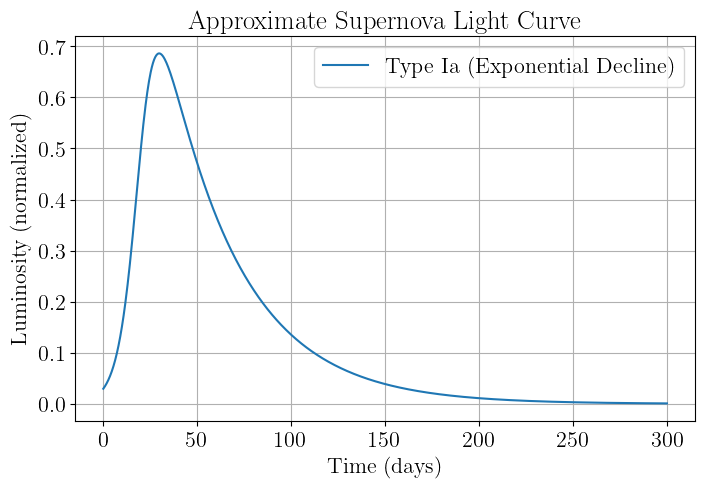

In [48]:
# Smooth logistic function for transition
def smooth_transition(t, t_half, width=5.0):
    """Smooth transition function using logistic sigmoid."""
    return 1 / (1 + jnp.exp(-(t - t_half) / width))

# Type Ia Supernova Light Curve (Smooth Peak + Exponential Decline)
@jax.jit
def type_ia_lc(t, t_peak=20.0, L_peak=1.0, tau_decay=40.0, width=5.0):
    """Smooth Type Ia supernova light curve using JAX."""
    rise = L_peak * smooth_transition(t, t_peak, width)  # Smooth rise
    decline = L_peak * jnp.exp(-(t - t_peak) / tau_decay)  # Exponential decline
    return rise * decline

# Time range (0 to 300 days)
t = jnp.linspace(0, 300, 1000)

# Compute light curves
L_ia = type_ia_lc(t)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_ia, label="Type Ia (Exponential Decline)", linestyle='-')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

Now how in the example we have *cheated*. We have used an array for the time steps of our light-curves, and JAX has complied the function on its own for a vectorized input to the time `t` argument.

Let's now vectorize `type_ia_lc` properly:

In [49]:
from jax import vmap

type_ia_lc_time_vmap = vmap(type_ia_lc, in_axes=[0, None, None, None, None])

# default values for (t_peak, L_peak, tau_decay, width)
default_vals = (20.0, 1.0, 40.0, 5.0)

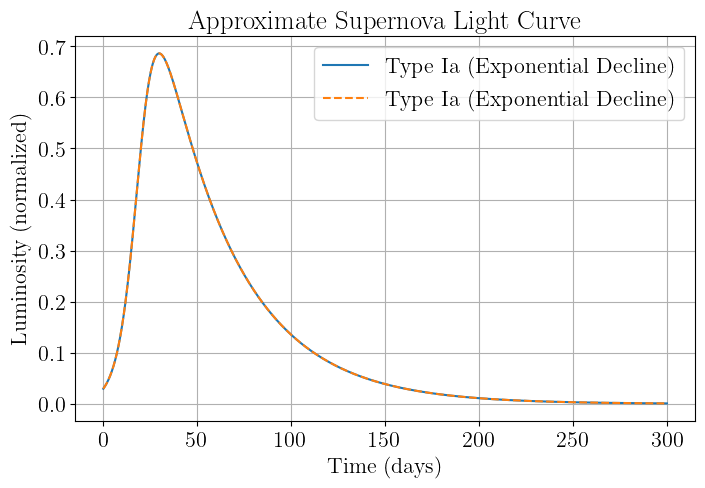

In [50]:
# Time range (0 to 300 days)
t = jnp.linspace(0, 300, 1000)

# Compute light curves
L_ia_vmap = type_ia_lc_time_vmap(t, *default_vals)

# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_ia, label="Type Ia (Exponential Decline)", linestyle='-')
plt.plot(t, L_ia_vmap, label="Type Ia (Exponential Decline)", linestyle='--')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.legend()
plt.grid()
plt.show()

Now let's imagine we have a set of `L_peak` and `width` values for a population of supernovas:

Text(0, 0.5, 'Curve width')

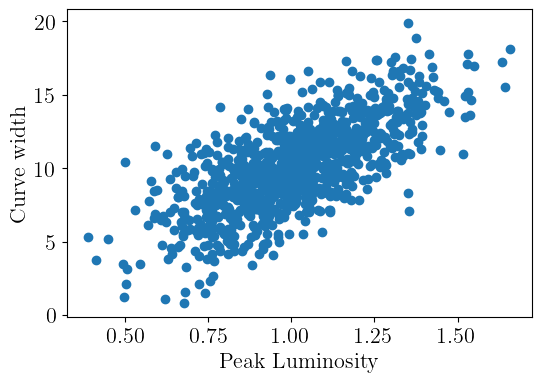

In [51]:
mu = [1.0, 10.0]
rho = 0.7
std = np.array([0.2, 3.0])
cov = np.identity(2) * std**2  + rho * np.prod(std) * (np.ones((2, 2)) - np.identity(2))
L_peak_arr, width_arr = np.random.multivariate_normal(mu, cov, size=int(1e3)).T

plt.scatter(L_peak_arr, width_arr)
plt.xlabel("Peak Luminosity")
plt.ylabel("Curve width")

In [52]:
# First vmap on the time axis
type_ia_lc_time_vmap = vmap(type_ia_lc, in_axes=[0, None, None, None, None])
# Then vmap on the Lpeak and width axes
type_ia_lc_L_w_vmap = jjit(vmap(type_ia_lc_time_vmap, in_axes=[None, None, 0, None, 0]))

# Let's get 30 supernovas, and 1000 time steps:

N_sn = 30
L_peak_arr, width_arr = np.random.multivariate_normal(mu, cov, size=N_sn).T
# Time range (0 to 300 days)
t = jnp.linspace(0, 300, 1000)

# Compute light curves for all 30 supernovas, and at each of the 1000 time steps:
L_ia_vmap = type_ia_lc_L_w_vmap(t, 20.0, L_peak_arr, 40.0, width_arr)

print(L_ia_vmap.shape) # Output shape: (30, 1000)

(30, 1000)


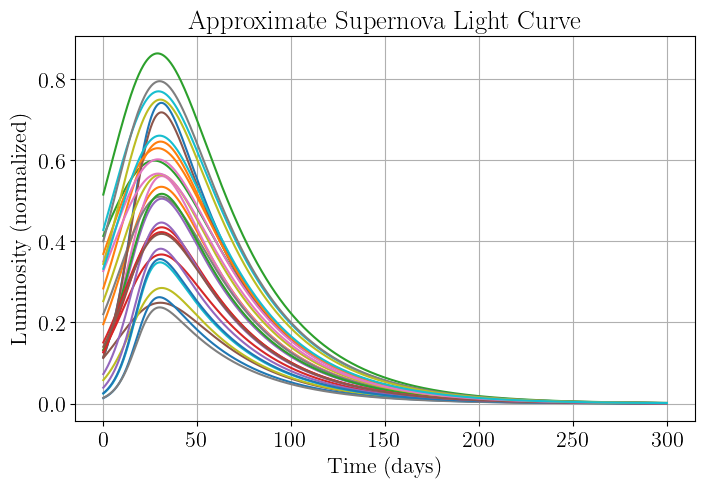

In [53]:
# Plot the supernova light curves
plt.figure(figsize=(8, 5))
plt.plot(t, L_ia_vmap.T, linestyle='-')

# plt.yscale('symlog', linthresh=0.1)  # Supernova light curves are usually plotted in log scale
# plt.yscale('log')
plt.xlabel("Time (days)")
plt.ylabel("Luminosity (normalized)")
plt.title("Approximate Supernova Light Curve")
plt.grid()
plt.show()

# Automatic differentiation

In JAX, you can differentiate a scalar-valued function with the `jax.grad()` transformation.

`jax.grad()` takes a function and returns a function. If you have a Python function `f` that evaluates the mathematical function $f$, then `jax.grad(f)` is a Python function that evaluates the mathematical function $\nabla f$. That means `grad(f)(x)` represents the value $\nabla f(x)$.



In [54]:
from jax import grad
@jjit
def fun(x):
    return jnp.sin(x)

fun_grad = grad(fun, argnums=0)
fun_grad_vmap = jjit(vmap(fun_grad))

print(fun(jnp.pi))
print(fun_grad(jnp.pi))

-8.742278e-08
-1.0


Importantly, `jax.grad` only accepts functions that return *scalar ouputs*.


In [55]:
x = jnp.linspace(0, 2*jnp.pi, 100)
fun_grad(x) # This fails

TypeError: Gradient only defined for scalar-output functions. Output had shape: (100,).

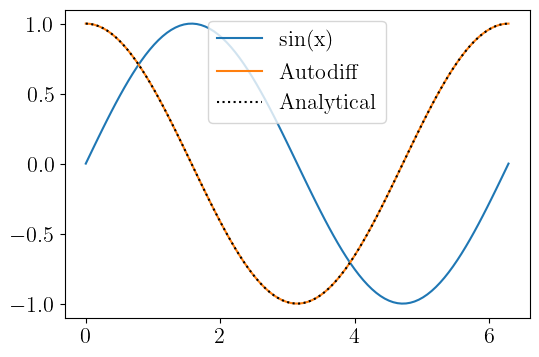

In [56]:
# Using the vmapped grad function.

x = jnp.linspace(0, 2*jnp.pi, 100)

plt.plot(x, fun(x), label='sin(x)')
plt.plot(x, fun_grad_vmap(x), label='Autodiff')
plt.plot(x, jnp.cos(x), ls=":", color='k', label='Analytical')
plt.legend()
plt.show()

Since `jax.grad()` operates on functions, you can apply it to its own output to differentiate as many times as you like:

In [57]:
from jax import grad

def fun(x):
    return jnp.sin(x)

fun_grad = grad(fun, argnums=0)
fun_grad_grad = grad(fun_grad, argnums=0)
fun_grad_grad_grad = grad(fun_grad_grad, argnums=0)

# simply vmap and jjit
fun_grad = jjit(vmap(fun_grad))
fun_grad_grad = vmap(fun_grad_grad)
fun_grad_grad_grad = jjit(vmap(fun_grad_grad_grad))

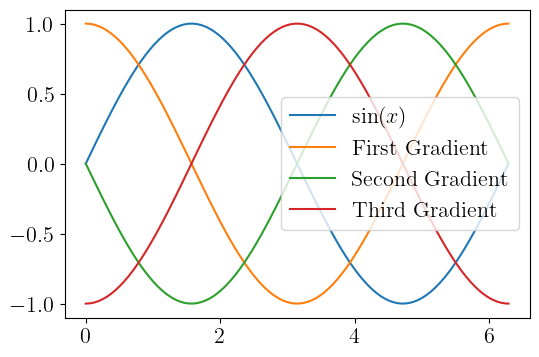

In [58]:
x = jnp.linspace(0, 2*jnp.pi, 100)

plt.plot(x, fun(x), label=r'$\sin(x)$')
plt.plot(x, fun_grad(x), label='First Gradient')
plt.plot(x, fun_grad_grad(x), label='Second Gradient')
plt.plot(x, fun_grad_grad_grad(x), label='Third Gradient')
plt.legend()
plt.show()

Now, going back to our funny little model, we can calculate the gradients with respect to the four parameters of our model:

 `(t_peak, L_peak, tau_decay, width)`

In [59]:
type_ia_lc_grad = grad(type_ia_lc, argnums=(1,2,3,4))

type_ia_lc_grad(100.0, *default_vals)

(Array(0.00338338, dtype=float32, weak_type=True),
 Array(0.27067053, dtype=float32, weak_type=True),
 Array(0.00676676, dtype=float32, weak_type=True),
 Array(-4.873592e-08, dtype=float32, weak_type=True))

JAX can also differentiate with respect to nested lists, tuples, and dicts.

In [60]:
params_dict = dict(zip(("t_peak", "L_peak", "tau_decay", "width"), default_vals))

@jax.jit
def type_ia_lc(t, params):
    t_peak = params["t_peak"]
    L_peak = params["L_peak"]
    tau_decay = params["tau_decay"]
    width = params["width"]
    """Smooth Type Ia supernova light curve using JAX."""
    rise = L_peak * smooth_transition(t, t_peak, width)  # Smooth rise
    decline = L_peak * jnp.exp(-(t - t_peak) / tau_decay)  # Exponential decline
    return rise * decline

type_ia_lc_grad = grad(type_ia_lc, argnums=1)

type_ia_lc_grad(100.0, params_dict)

{'L_peak': Array(0.27067053, dtype=float32, weak_type=True),
 't_peak': Array(0.00338338, dtype=float32, weak_type=True),
 'tau_decay': Array(0.00676676, dtype=float32, weak_type=True),
 'width': Array(-4.873592e-08, dtype=float32, weak_type=True)}

In [61]:
from collections import namedtuple

Params = namedtuple("LightCurveParams", list(params_dict.keys()))

@jax.jit
def type_ia_lc(t, params):
    """Smooth Type Ia supernova light curve using JAX."""
    rise = params.L_peak * smooth_transition(t, params.t_peak, params.width)  # Smooth rise
    decline = params.L_peak * jnp.exp(-(t - params.t_peak) / params.tau_decay)  # Exponential decline
    return rise * decline

type_ia_lc_grad = grad(type_ia_lc, argnums=1)

PARAMS = Params(**params_dict)
type_ia_lc_grad(100.0, PARAMS)

LightCurveParams(t_peak=Array(0.00338338, dtype=float32, weak_type=True), L_peak=Array(0.27067053, dtype=float32, weak_type=True), tau_decay=Array(0.00676676, dtype=float32, weak_type=True), width=Array(-4.873592e-08, dtype=float32, weak_type=True))